# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### Descripción
El Dataset presenta una coleccion de criticas de usuarios de "Amazon". Cuenta con opiniones en español recolectadas entre noviembre de 2015 hasta noviembre de 2019. Cada comentario contiene: ID de critica, ID de producto, ID de usuario, cantidad de estrellas, descripción, título, lenguaje (en este caso todo es en español) y categoría del producto.

El Dataset esta dividido en 3 archivos, uno para entrenamiento, otro para testeo y el ultimo para validación.

In [1]:
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import re 
from collections import Counter
from wordcloud import WordCloud 

In [2]:
# Cargo los dataset
data_train = pd.read_json('dataset_es_train.json', lines=True)
data_dev = pd.read_json('dataset_es_dev.json', lines=True)
data_test = pd.read_json('dataset_es_test.json', lines=True)

data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [3]:
print('Shape: ', data_train.shape)
print('Instancias: ', data_train.shape[0])
print('Columnas: ', data_train.columns)

Shape:  (200000, 8)
Instancias:  200000
Columnas:  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')


In [4]:
data_train['stars'].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

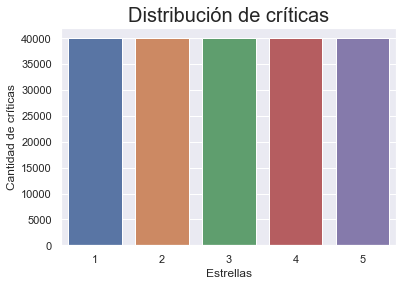

In [5]:
sns.countplot(x = "stars", data = data_train)
plt.title('Distribución de críticas', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')
plt.show()

Como se observa en el gráfico las datos estan prefectamente distribuidos, esto es óptimo para trabajar.

In [6]:
# Controlo si todas las críticas estan en español
data_train['language'].value_counts()

es    200000
Name: language, dtype: int64

In [7]:
print('Cantidad de usuarios:', len(data_train.reviewer_id.unique()))

Cantidad de usuarios: 179076


In [8]:
# ¿Hay datos faltantes?
data_train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [9]:
# Dataset de testeo
data_dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [10]:
print('Shape: ', data_dev.shape)
print('Instancias: ', data_dev.shape[0])
print('Columnas: ', data_dev.columns)

Shape:  (5000, 8)
Instancias:  5000
Columnas:  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')


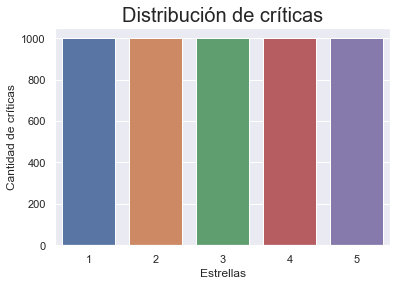

In [11]:
sns.countplot(x = "stars", data = data_dev)
plt.title('Distribución de críticas', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')
plt.show()

In [12]:
# ¿Hay datos faltantes?
data_dev.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [13]:
# Dataset de validación 
data_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


In [14]:
print('Shape: ', data_test.shape)
print('Instancias: ', data_test.shape[0])
print('Columnas: ', data_test.columns)

Shape:  (5000, 8)
Instancias:  5000
Columnas:  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')


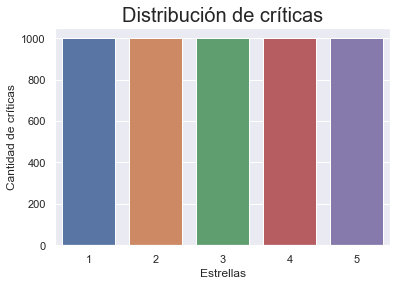

In [15]:
sns.countplot(x = "stars", data = data_test)
plt.title('Distribución de críticas', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')
plt.show()

In [16]:
# ¿Hay datos faltantes?
data_test.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [17]:
# ¿Cuántas veces dejaron una review cada usuarios?
data_train.reviewer_id.value_counts()

reviewer_es_0431022    7
reviewer_es_0437514    7
reviewer_es_0588051    7
reviewer_es_0691152    6
reviewer_es_0035822    6
                      ..
reviewer_es_0827662    1
reviewer_es_0554886    1
reviewer_es_0350679    1
reviewer_es_0569607    1
reviewer_es_0022186    1
Name: reviewer_id, Length: 179076, dtype: int64

In [18]:
# Vamos a ver cuales fueron sus experiencias
data_train[data_train.reviewer_id == 'reviewer_es_0431022']

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
9219,es_0555103,product_es_0633037,reviewer_es_0431022,1,"Mala elección, talla super pequeño, no lo devo...",no me gusto nada,es,apparel
15119,es_0043301,product_es_0918078,reviewer_es_0431022,1,"Lo tuve que devolver, se veía muy endeble y no...",endeble,es,electronics
72673,es_0364344,product_es_0065839,reviewer_es_0431022,2,"Se rompió a la primera caída, creo q no son mu...",No lo recomiendo,es,wireless
94225,es_0969476,product_es_0466804,reviewer_es_0431022,3,"Colores bonitos, tacto agradable, es suficient...",buena compra,es,apparel
154303,es_0419561,product_es_0159509,reviewer_es_0431022,4,"A mi hija le encanto, viene el hada con el cie...",muy bonita,es,toy
168351,es_0547249,product_es_0226318,reviewer_es_0431022,5,"Preciosa, de acabados buenos, cose de maravill...",Amor puro,es,home
169020,es_0279159,product_es_0499936,reviewer_es_0431022,5,"Resistente, bonita, de buena calidad la recomi...",Muy buena,es,wireless


In [19]:
# ¿Cuántas categorías hay?
print('Cantidad de categorías:', len(data_train.product_category.unique()))

Cantidad de categorías: 30


In [20]:
# ¿Cuál es el puntaje promedio por tipo de producto?

best = data_train.groupby(['product_category'])[['stars']].mean()
best = best.dropna(axis=0)
best = best.sort_values(by=['stars'], ascending=False)
print(best)

                             stars
product_category                  
book                      3.399316
digital_ebook_purchase    3.357027
luggage                   3.293570
musical_instruments       3.225490
grocery                   3.147510
video_games               3.124639
shoes                     3.109296
camera                    3.109277
baby_product              3.089326
office_product            3.086565
other                     3.079756
industrial_supplies       3.078947
pc                        3.062550
furniture                 3.048958
toy                       3.042061
home_improvement          3.036584
sports                    3.034650
personal_care_appliances  3.022950
kitchen                   3.016281
drugstore                 3.010521
watch                     3.001342
pet_products              2.991112
home                      2.980380
automotive                2.950721
beauty                    2.935805
jewelry                   2.930538
electronics         

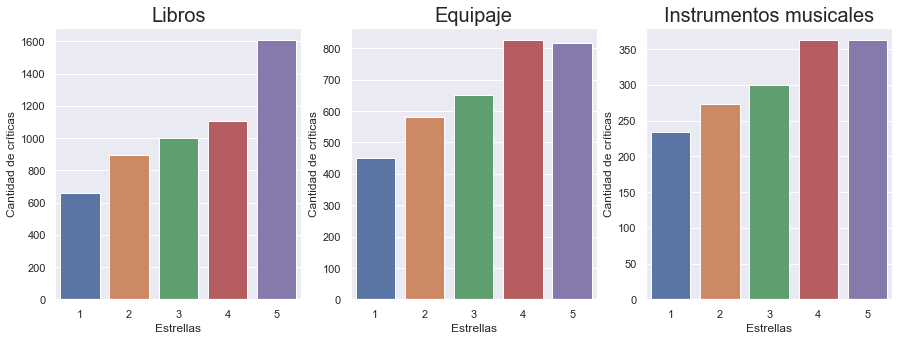

In [21]:
# Top 3 de mejores puntuaciones por categoría de producto
plt.figure(figsize=(15,5))

plt.subplot(131)
sns.countplot(x = "stars", data = data_train[data_train['product_category']== 'book'])
plt.title('Libros', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')

plt.subplot(132)
sns.countplot(x = "stars", data = data_train[data_train['product_category']== 'luggage'])
plt.title('Equipaje', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')

plt.subplot(133)
sns.countplot(x = "stars", data = data_train[data_train['product_category']== 'musical_instruments'])
plt.title('Instrumentos musicales', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')

plt.show()

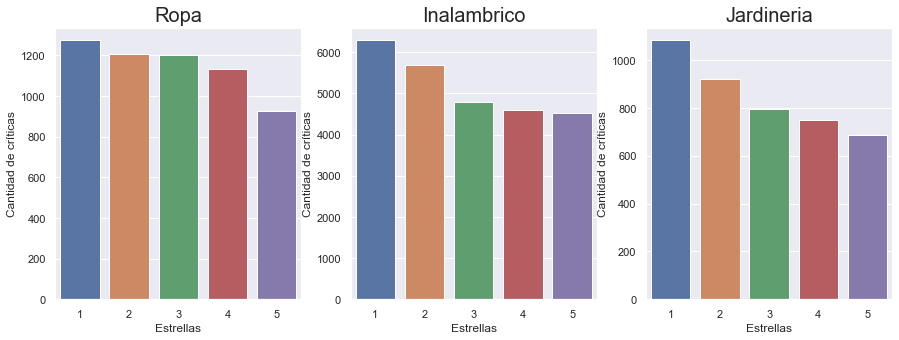

In [22]:
# Top 3 de peores puntuaciones por categoría de producto
plt.figure(figsize=(15,5))

plt.subplot(131)
sns.countplot(x = "stars", data = data_train[data_train['product_category']== 'apparel'])
plt.title('Ropa', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')

plt.subplot(132)
sns.countplot(x = "stars", data = data_train[data_train['product_category']== 'wireless'])
plt.title('Inalambrico', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')

plt.subplot(133)
sns.countplot(x = "stars", data = data_train[data_train['product_category']== 'lawn_and_garden'])
plt.title('Jardineria', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')

plt.show()

In [23]:
# ¿Cuáles son las categorías con mas críticas?
data_train['product_category'].value_counts()

home                        26962
wireless                    25886
toy                         13647
sports                      13189
pc                          11191
home_improvement            10879
electronics                 10385
beauty                       7337
automotive                   7143
kitchen                      6695
apparel                      5737
drugstore                    5513
book                         5264
furniture                    5229
baby_product                 4881
office_product               4771
lawn_and_garden              4237
other                        3937
pet_products                 3713
personal_care_appliances     3573
luggage                      3328
camera                       3029
shoes                        2754
digital_ebook_purchase       1843
video_games                  1733
jewelry                      1598
musical_instruments          1530
watch                        1490
industrial_supplies          1482
grocery       

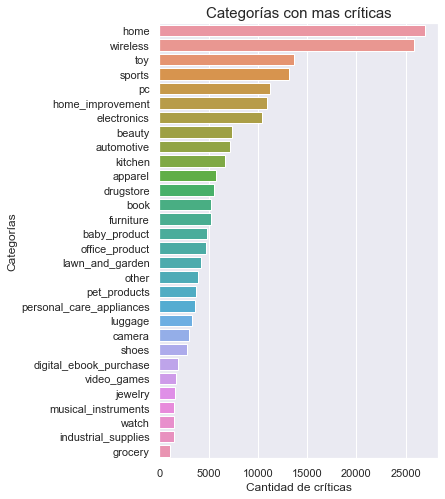

In [24]:
plt.figure(figsize = (5,8))
sns.countplot(data = data_train, y  = 'product_category', order = data_train['product_category'].value_counts().index)
plt.title('Categorías con mas críticas', fontsize=15)
plt.xlabel('Cantidad de críticas')
plt.ylabel('Categorías')
plt.show()

In [25]:
# Elimino las columnas que no son de interés
data_train1 = data_train.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id'])
data_train1.head()

,stars,review_body,review_title,product_category
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes


In [26]:
# Creo una columna que reúna el título y el cuerpo de la crítica para un análisis más completo
data_train1['review_full'] = data_train1['review_title'] + ' ' + data_train1['review_body']
data_train1.head()

,stars,review_body,review_title,product_category,review_full
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television Nevir Nada bueno se me fue ka panta...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,Dinero tirado a la basura con esta compra Horr...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,solo llega una unidad cuando te obligan a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,Devuelto Llega tarde y co la talla equivocada


In [27]:
# Para generar un análisis se tiene que crear un objeto del modelo en español
nlp = spacy.load("es_core_news_lg")

In [28]:
# Creo una nueva columna con las palabras de la columna review_full lematizadas.
#data_train1['review_lemm'] = '' # la inicializamos con un string vacio
#stop_words = nlp.Defaults.stop_words
#
#for i in range(data_train1.shape[0]):
#    review = data_train1.iloc[i].review_full #seleccionar el titular
#    review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
#    review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
#    review_clean = ' '.join(review_tk_lower_stop)
#    review_clean = nlp(review_clean)
#    lemmas_list = [word.lemma_ for word in review_clean]
#    data_train1['review_lemm'].iloc[i] = ' '.join(lemmas_list)
#    
#data_train1.to_csv('DS_Proyecto_03_data_train_lemma.csv', index = False, encoding = 'utf-8')

Para no tener que esperar la ejecucion de la celda anterior, guardo el dataset obtenido en el equipo y luego lo llamo para seguir trabajando.

In [29]:
data_train1 = pd.read_csv('DS_Proyecto_03_data_train_lemma.csv')
data_train1['review_lemm'] = data_train1['review_lemm'].apply(str)
data_train1.head()

,stars,review_body,review_title,product_category,review_full,review_lemm
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television Nevir Nada bueno se me fue ka panta...,television nevir ka pantalla 8 mesar y recibir...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,Dinero tirado a la basura con esta compra Horr...,dinero tirar a basura comprar horrible tener c...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar a comprar obligar a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto recibir entrar descalificar vendedor ...
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,Devuelto Llega tarde y co la talla equivocada,devolver llegar y co tallar equivocar


In [30]:
# Divido el dataset por sus calificaciones y analiso
df_1s = data_train1[data_train1.stars == 1]
df_2s = data_train1[data_train1.stars == 2]
df_3s = data_train1[data_train1.stars == 3]
df_4s = data_train1[data_train1.stars == 4]
df_5s = data_train1[data_train1.stars == 5]

In [31]:
# Shape de las críticas de 1 estrella
df_1s.shape

(40000, 6)

In [32]:
r_1s = []
for i in range(df_1s.shape[0]):
    titular = df_1s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_1s.append(titular) #agregar el resultado a la lista
    
r_1s = list(itertools.chain(*r_1s))

word_freq = Counter(r_1s)
common_words_1s = word_freq.most_common()

print('Lista de palabras más comunes para críticas de 1 estrella')
df_r_1s = pd.DataFrame(common_words_1s, columns = ['Words', 'Frequency'])
df_r_1s.head(15)

Lista de palabras más comunes para críticas de 1 estrella


,Words,Frequency
0,producto,9518
1,llegar,9406
2,comprar,9233
3,malo,8440
4,funcionar,7576
5,calidad,6782
6,devolver,4525
7,pedir,4482
8,venir,4074
9,recibir,3960


In [33]:
r_2s = []
for i in range(df_2s.shape[0]):
    titular = df_2s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_2s.append(titular) #agregar el resultado a la lista
    
r_2s = list(itertools.chain(*r_2s))

word_freq = Counter(r_2s)
common_words_2s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 2 estrellas')
df_r_2s = pd.DataFrame(common_words_2s, columns = ['Words', 'Frequency'])
df_r_2s.head(15)

Lista de palabras más comunes para críticas de 2 estrellas


,Words,Frequency
0,calidad,8838
1,comprar,7048
2,producto,5881
3,funcionar,5637
4,malo,5058
5,pequeño,4380
6,venir,4355
7,esperar,4082
8,preciar,3981
9,llegar,3955


In [34]:
r_3s = []
for i in range(df_3s.shape[0]):
    titular = df_3s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_3s.append(titular) #agregar el resultado a la lista
    
r_3s = list(itertools.chain(*r_3s))

word_freq = Counter(r_3s)
common_words_3s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 3 estrellas')
df_r_3s = pd.DataFrame(common_words_3s, columns = ['Words', 'Frequency'])
df_r_3s.head(15)

Lista de palabras más comunes para críticas de 3 estrellas


,Words,Frequency
0,calidad,8536
1,preciar,7274
2,producto,5270
3,pequeño,4752
4,comprar,4655
5,esperar,4268
6,funcionar,4075
7,gustar,3930
8,venir,3793
9,bonito,3476


In [35]:
r_4s = []
for i in range(df_4s.shape[0]):
    titular = df_4s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_4s.append(titular) #agregar el resultado a la lista
    
r_4s = list(itertools.chain(*r_4s))

word_freq = Counter(r_4s)
common_words_4s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 4 estrellas')
df_r_4s = pd.DataFrame(common_words_4s, columns = ['Words', 'Frequency'])
df_r_4s.head(15)

Lista de palabras más comunes para críticas de 4 estrellas


,Words,Frequency
0,calidad,11353
1,preciar,10454
2,producto,6381
3,comprar,6164
4,perfecto,5190
5,cumplir,4802
6,gustar,4232
7,funcionar,4000
8,bonito,3751
9,esperar,3420


In [36]:
r_5s = []
for i in range(df_5s.shape[0]):
    titular = df_5s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_5s.append(titular) #agregar el resultado a la lista
    
r_5s = list(itertools.chain(*r_5s))

word_freq = Counter(r_5s)
common_words_5s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 5 estrellas')
df_r_5s = pd.DataFrame(common_words_5s, columns = ['Words', 'Frequency'])
df_r_5s.head(15)

Lista de palabras más comunes para críticas de 5 estrellas


,Words,Frequency
0,calidad,12174
1,perfecto,10977
2,comprar,8754
3,preciar,8223
4,producto,6579
5,encantar,4966
6,genial,3918
7,bonito,3793
8,funcionar,3656
9,gustar,3479


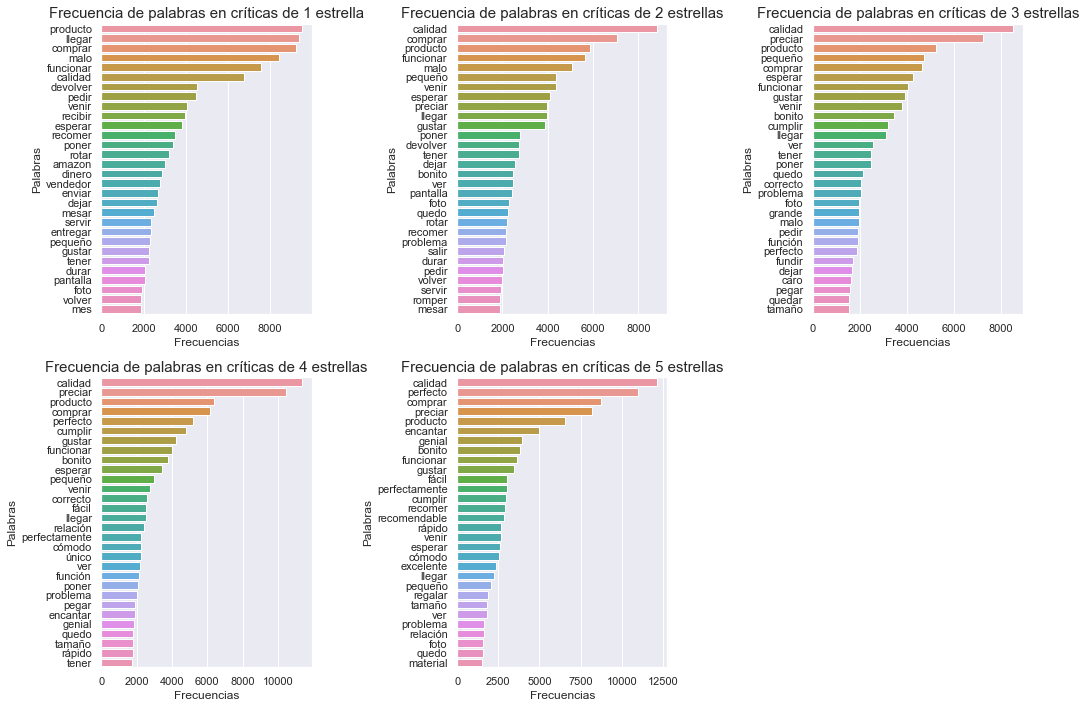

In [37]:
plt.figure(figsize = (15,10))

plt.subplot(231)
plot = sns.barplot(y  = df_r_1s.iloc[:30].Words, x = df_r_1s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 1 estrella', fontsize=15)
plt.xlabel('Frecuencias')
plt.ylabel('Palabras')

plt.subplot(232)
plot = sns.barplot(y  = df_r_2s.iloc[:30].Words, x = df_r_2s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 2 estrellas', fontsize=15)
plt.xlabel('Frecuencias')
plt.ylabel('Palabras')

plt.subplot(233)
plot = sns.barplot(y  = df_r_3s.iloc[:30].Words, x = df_r_3s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 3 estrellas', fontsize=15)
plt.xlabel('Frecuencias')
plt.ylabel('Palabras')

plt.subplot(234)
plot = sns.barplot(y  = df_r_4s.iloc[:30].Words, x = df_r_4s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 4 estrellas', fontsize=15)
plt.xlabel('Frecuencias')
plt.ylabel('Palabras')

plt.subplot(235)
plot = sns.barplot(y  = df_r_5s.iloc[:30].Words, x = df_r_5s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 5 estrellas', fontsize=15)
plt.xlabel('Frecuencias')
plt.ylabel('Palabras')

plt.tight_layout()
plt.show()

Se puede apreciar una gran similitud respecto a las frecuencias de palabras en criticas de 1 y 2 estrellas, lo mismo para el caso de críticas de 4 y 5 estrellas. Las reviews con 3 estrellas de calificación son bastante neutras, pero se podria agrupar con opiniones negativas (1 y 2 estrellas). 

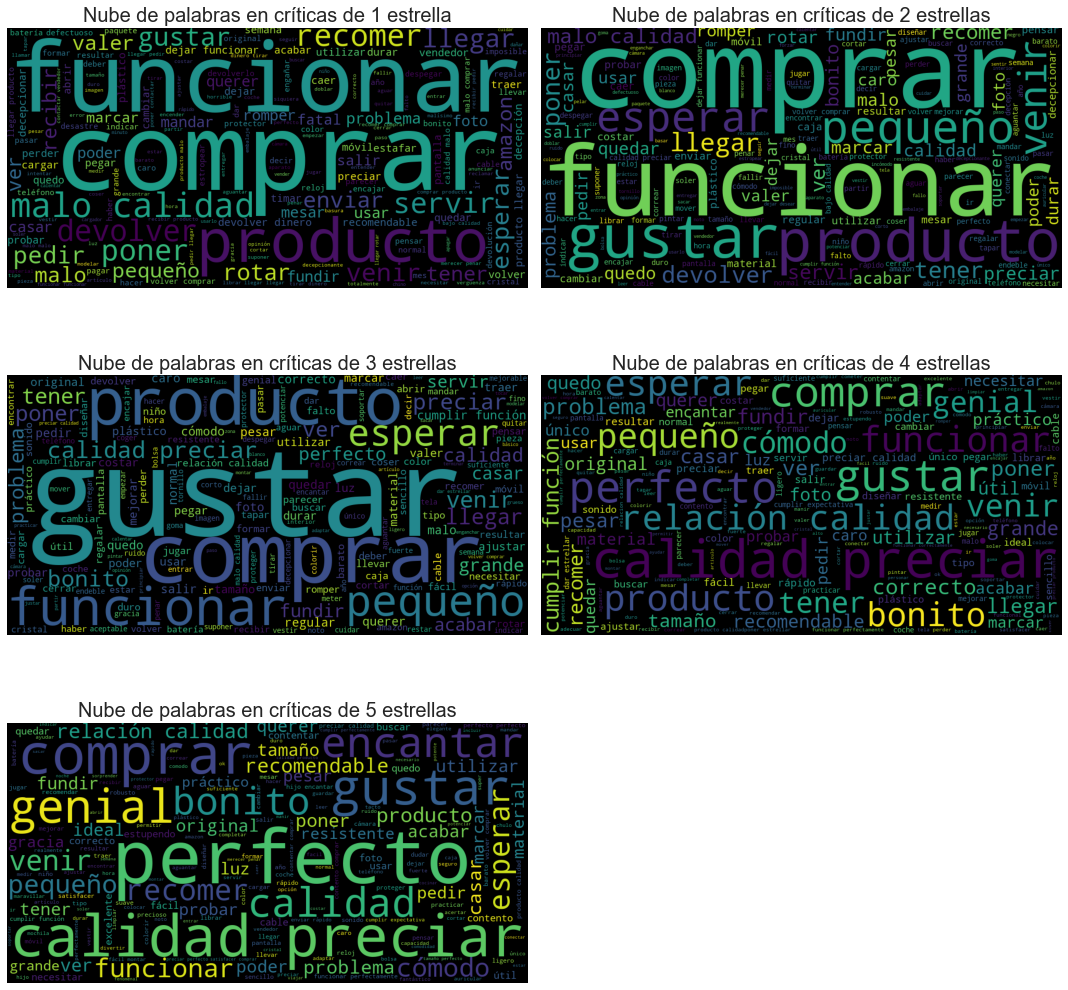

In [38]:
plt.figure(figsize=(15,15))

plt.subplot(321)
unique_string=(" ").join(r_1s)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de palabras en críticas de 1 estrella', fontsize=20)

plt.subplot(322)
unique_string=(" ").join(r_2s)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de palabras en críticas de 2 estrellas', fontsize=20)

plt.subplot(323)
unique_string=(" ").join(r_3s)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de palabras en críticas de 3 estrellas', fontsize=20)

plt.subplot(324)
unique_string=(" ").join(r_4s)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de palabras en críticas de 4 estrellas', fontsize=20)

plt.subplot(325)
unique_string=(" ").join(r_5s)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de palabras en críticas de 5 estrellas', fontsize=20)

plt.tight_layout()
plt.show()

Con el recurso de nube de palabras se puede observar mejor la similitud entre opiniones negativas (1, 2 y 3 estrellas) y positivas (4 y 5 estrellas). El tamaño de cada palabra indica su frecuencia o importancia en las críticas. 

In [39]:
# Creo una columna con la cuenta de caracteres por crítica
data_train1['count_word'] = data_train1["review_full"].apply(lambda x: len(str(x).split()))
data_train1.head()

,stars,review_body,review_title,product_category,review_full,review_lemm,count_word
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television Nevir Nada bueno se me fue ka panta...,television nevir ka pantalla 8 mesar y recibir...,21
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,Dinero tirado a la basura con esta compra Horr...,dinero tirar a basura comprar horrible tener c...,31
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar a comprar obligar a comp...,32
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto recibir entrar descalificar vendedor ...,63
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,Devuelto Llega tarde y co la talla equivocada,devolver llegar y co tallar equivocar,8


In [40]:
data_train1.tail()

,stars,review_body,review_title,product_category,review_full,review_lemm,count_word
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,electronics,Tal y como se describe Mando funciona perfecta...,y describir mandar funcionar perfectamente y c...,28
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,electronics,Funciona perfectamente Compré la batería con c...,funcionar perfectamente comprar batería retice...,30
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,apparel,Buena calidad. Buena calidad. Satisfecha con l...,calidad calidad satisfacer comprar,8
199998,5,Perfecto para el cumple de mi hijo,Recomendado,toy,Recomendado Perfecto para el cumple de mi hijo,recomendar perfecto cumplir hijo,8
199999,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,home,"Preciosas Súper bien! Las brochas son buenas, ...",precioso súper brocha caer pelitos pesar chulo xd,26


In [41]:
#¿Cual es el número de palabras promedio por estrellas?

best = data_train1.groupby(['stars'])[['count_word']].mean()
best = best.dropna(axis=0)
print(best)

       count_word
stars            
1       32.015575
2       35.005000
3       32.263400
4       28.936725
5       27.383200


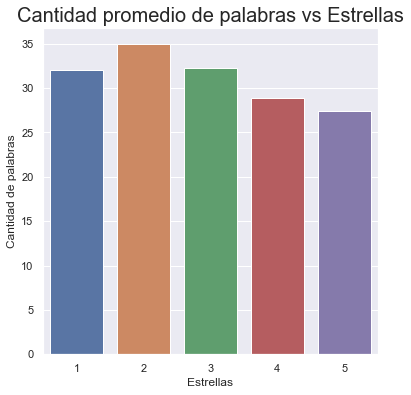

In [42]:
plt.figure(figsize=(6,6))
sns.barplot(data = data_train1, x = "stars", y = "count_word", ci = None )
plt.title('Cantidad promedio de palabras vs Estrellas', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de palabras')
plt.show()

Se observa que si la crítica es negativa tiende a ser más extensa que los casos cuando son positivas.

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

A continuación realizo las transformaciones de los datos de los distintos dataset para poder modelar y evaluar resultados.

In [44]:
data_dev['review_full'] = data_dev['review_title'] + ' ' + data_dev['review_body']
data_dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_full
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,"Mala compra Malisimo, muy grande demasiado apa..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,No lo he recibido No he recibido el pedido no ...
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,Que no aprieta bien en el manillar Tengo que b...
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Brocas de mantequilla Utilicé las brocas de me...
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,No me gusta No me gusta su olor a viejo y aspe...


In [45]:
# Elimino las columnas que no son de interés
data_dev1 = data_dev.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])
data_dev1.head()

,stars,product_category,review_full
0,1,wireless,"Mala compra Malisimo, muy grande demasiado apa..."
1,1,apparel,No lo he recibido No he recibido el pedido no ...
2,1,sports,Que no aprieta bien en el manillar Tengo que b...
3,1,home_improvement,Brocas de mantequilla Utilicé las brocas de me...
4,1,beauty,No me gusta No me gusta su olor a viejo y aspe...


In [46]:
data_dev1['count_word'] = data_dev1["review_full"].apply(lambda x: len(str(x).split()))
data_dev1.head()

,stars,product_category,review_full,count_word
0,1,wireless,"Mala compra Malisimo, muy grande demasiado apa...",12
1,1,apparel,No lo he recibido No he recibido el pedido no ...,12
2,1,sports,Que no aprieta bien en el manillar Tengo que b...,35
3,1,home_improvement,Brocas de mantequilla Utilicé las brocas de me...,55
4,1,beauty,No me gusta No me gusta su olor a viejo y aspe...,13


In [47]:
# Creo una nueva columna con las palabras de la columna review full lematizadas.
#data_dev1['review_lemm'] = '' # la inicializamos con un string vacio
#stop_words = nlp.Defaults.stop_words

#for i in range(data_dev1.shape[0]):
#    review = data_dev1.iloc[i].review_full #seleccionar el titular
#    review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
#    review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
#    review_clean = ' '.join(review_tk_lower_stop)
#    review_clean = nlp(review_clean)
#    lemmas_list = [word.lemma_ for word in review_clean]
#    data_dev1['review_lemm'].iloc[i] = ' '.join(lemmas_list)
    
#data_dev1.to_csv('DS_Proyecto_03_data_dev_lemma.csv', index = False, encoding = 'utf-8')

In [48]:
data_dev1 = pd.read_csv('DS_Proyecto_03_data_dev_lemma.csv')
data_dev1['review_lemm'] = data_dev1['review_lemm'].apply(str)
data_dev1.head()

,stars,product_category,review_full,count_word,review_lemm
0,1,wireless,"Mala compra Malisimo, muy grande demasiado apa...",12,malo comprar malisimo grande aparatoso y prote...
1,1,apparel,No lo he recibido No he recibido el pedido no ...,12,recibir recibir pedir devolución
2,1,sports,Que no aprieta bien en el manillar Tengo que b...,35,apretar manillar buscar sistema funcionar abra...
3,1,home_improvement,Brocas de mantequilla Utilicé las brocas de me...,55,broca mantequilla utilizar broca menor diámetr...
4,1,beauty,No me gusta No me gusta su olor a viejo y aspe...,13,gustar gustar olor a viejo y aspecto malo


In [49]:
data_test['review_full'] = data_test['review_title'] + ' ' + data_test['review_body']
data_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_full
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless,no me llego no me llego el articulo me lo mand...
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home,amazon sigue sin cumplir en las entregas la me...
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home,Estafa de Amazon Mi valoración no es sobre el ...
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...


In [50]:
# Elimino las columnas que no son de interés
data_test1 = data_test.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])
data_test1.head()

,stars,product_category,review_full
0,1,wireless,no me llego no me llego el articulo me lo mand...
1,1,home,amazon sigue sin cumplir en las entregas la me...
2,1,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...
3,1,home,Estafa de Amazon Mi valoración no es sobre el ...
4,1,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...


In [51]:
data_test1['count_word'] = data_test1["review_full"].apply(lambda x: len(str(x).split()))
data_test1.head()

,stars,product_category,review_full,count_word
0,1,wireless,no me llego no me llego el articulo me lo mand...,23
1,1,home,amazon sigue sin cumplir en las entregas la me...,13
2,1,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...,49
3,1,home,Estafa de Amazon Mi valoración no es sobre el ...,88
4,1,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...,53


In [52]:
# Creo una nueva columna con las palabras de la columna review full lematizadas.
#data_test1['review_lemm'] = '' # la inicializamos con un string vacio
#stop_words = nlp.Defaults.stop_words

#for i in range(data_test1.shape[0]):
#    review = data_test1.iloc[i].review_full #seleccionar el titular
#    review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
#    review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
#    review_clean = ' '.join(review_tk_lower_stop)
#    review_clean = nlp(review_clean)
#    lemmas_list = [word.lemma_ for word in review_clean]
#    data_test1['review_lemm'].iloc[i] = ' '.join(lemmas_list)
    
#data_test1.to_csv('DS_Proyecto_03_data_test_lemma.csv', index = False, encoding = 'utf-8')

In [53]:
data_test1 = pd.read_csv('DS_Proyecto_03_data_test_lemma.csv')
data_test1['review_lemm'] = data_test1['review_lemm'].apply(str)
data_test1.head()

,stars,product_category,review_full,count_word,review_lemm
0,1,wireless,no me llego no me llego el articulo me lo mand...,23,llegar llegar articular mandar correo normal s...
1,1,home,amazon sigue sin cumplir en las entregas la me...,13,amazon cumplir entregar mensajería horrible co...
2,1,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...,49,estafar enviar decepcionar vendedor pedir a y ...
3,1,home,Estafa de Amazon Mi valoración no es sobre el ...,88,estafar amazon valoración producto amazon ofre...
4,1,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...,53,conseguir pasar portar kindle interés librar y...


#### Vectorizar
Hasta ahora, tenemos un grupo de palabras por cada crítica (bag of words), lematizado. La idea ahora es representar esta lista de palabras como un vector.

Primero utilizaré la herramienta de sklearn, CountVectorizer.

In [54]:
# Tomamos la lista de palabras y el vector que nos dice la calificación tanto para train y dev
list_review_train = list(data_train1['review_lemm'].values)
calif_train = data_train1['stars'].values

list_review_dev = list(data_dev1['review_lemm'].values)
calif_dev = data_dev1['stars'].values

# Preparamos el conversor de bag of words a vectores que traemos de sklearn.
# Debido a la capacidad de memoria disponible usaremos solo las 1000 palabras con mas frecuencia en todo el corpus 
# para generar los vectores
cou_vec=CountVectorizer(max_features=1000, min_df=30)

# generarnos los vectores para cada review a partir del corpus total.
matriz_review_train = cou_vec.fit_transform(list_review_train)
matriz_review_dev = cou_vec.transform(list_review_dev)

# Visualisamos el shape 
print(matriz_review_train.shape)
print(matriz_review_dev.shape)

(200000, 1000)
(5000, 1000)


In [55]:
# Cambio los tipos de datos de las matrices para mayor agilidad
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_dev = matriz_review_dev.astype('float32')
calif_dev = calif_dev.astype('int8')

### Modelado

In [56]:
# Defino x e y
x_train = matriz_review_train.toarray()
y_train = calif_train
x_dev = matriz_review_dev.toarray()
y_dev = calif_dev

In [57]:
# Funcion para visualizar matriz de confusión
def confusion(y_test,y_pred):
    names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

    return

#### Benchmark
Empecemos por un simple Naive Bayes para tener un benchmark de referencia para el accuracy.

In [60]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_train_pred = nb.predict(x_train)
y_dev_pred = nb.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.39368
acc dev:  0.3854


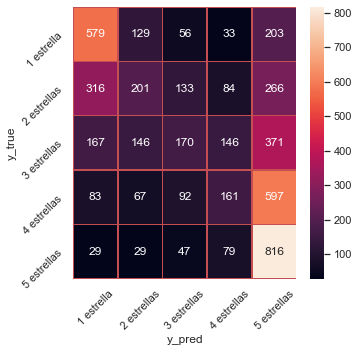

In [61]:
confusion(y_dev,y_dev_pred)

#### Random Forest

In [62]:
rf = RandomForestClassifier(max_depth=20, random_state=42)
rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)
y_dev_pred = rf.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.485795
acc dev:  0.424


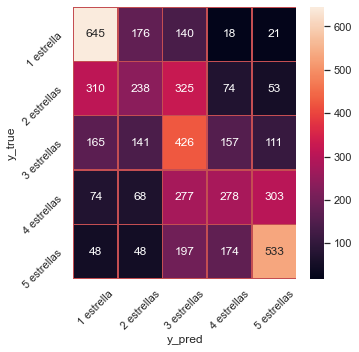

In [63]:
confusion(y_dev,y_dev_pred)

#### LinearSVC

In [64]:
svc = LinearSVC(C = 1, random_state=42)
svc.fit(x_train, y_train)
y_train_pred = svc.predict(x_train)
y_test_pred = svc.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.490355
acc dev:  0.424


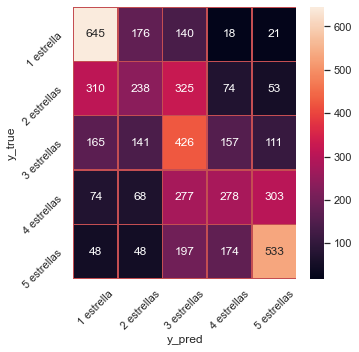

In [65]:
confusion(y_dev,y_dev_pred)

Se observan mejores resultados en RandomForest y LinearSVC comparado con el benchmark, pero se puede notar un overfitting en ambos casos.

La métrica utilizada es el Accuracy, al tener una dataset perfectamente balanceado es una muy buena medida, la presición es el porcentaje total de elementos clasificados correctamente.

Otra forma de ver los resultados de nuestro modelo de clasificaciíon es la **matriz de confusión**. La matriz de confusión es una tabla de doble entrada, donde un eje corresponde a la etiqueta real y otro a la etiqueta predicha. En la diagonal encontramos los aciertos, mientras que por fuera de la diagonal aquellas instancias mal clasificadas

#### TF-IDF
Se traduce como “frecuencia del término por frecuencia inversa de documento”. Es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección.

El valor tf-idf aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra en la colección de documentos, lo que permite manejar el hecho de que algunas palabras son generalmente más comunes que otras.

Para poder aplicar esto utilizaré la herramienta de sklearn, TfidfVectorizer. Esta se encarga de convertir una colección de documentos crudos a una matriz de caracteres TF-IDF.

In [66]:
# Tomamos la lista de palabras y el vector que nos dice la calificación tanto para train y dev
list_review_train = list(data_train1['review_lemm'].values)
calif_train = data_train1['stars'].values

list_review_dev = list(data_dev1['review_lemm'].values)
calif_dev = data_dev1['stars'].values

# Preparamos el conversor de bag of words a vectores que traemos de sklearn.
# Debido a la capacidad de memoria disponible usaremos solo las 1000 palabras con mas frecuencia en todo el corpus 
# para generar los vectores
vectorizer = TfidfVectorizer(max_features=1000, min_df=30)
# generarnos los vectores para cada review a partir del corpus total.
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_dev = vectorizer.transform(list_review_dev)

# Visualisamos el shape 
print(matriz_review_train.shape)
print(matriz_review_dev.shape)

(200000, 1000)
(5000, 1000)


In [67]:
# Cambio los tipos de datos de las matrices para mayor agilidad
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_dev = matriz_review_dev.astype('float32')
calif_dev = calif_dev.astype('int8')

In [68]:
x_train = matriz_review_train.toarray()
y_train = calif_train
x_dev = matriz_review_dev.toarray()
y_dev = calif_dev

#### Benchmark

In [69]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_train_pred = nb.predict(x_train)
y_dev_pred = nb.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.41667
acc dev:  0.4002


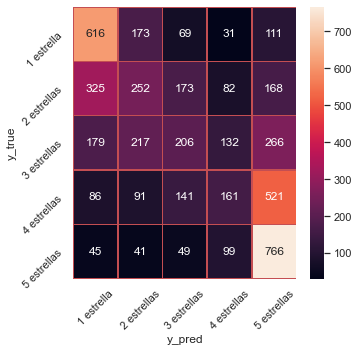

In [70]:
confusion(y_dev,y_dev_pred)

#### Random Forest

In [71]:
rf = RandomForestClassifier(max_depth=20, random_state=42)
rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)
y_dev_pred = rf.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.491955
acc dev:  0.425


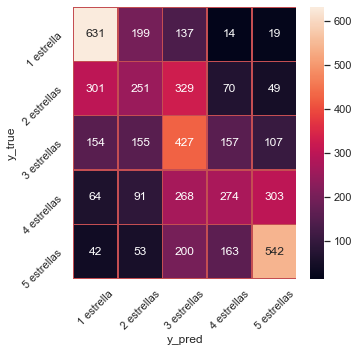

In [72]:
confusion(y_dev,y_dev_pred)

#### Linear SVC

In [73]:
svc = LinearSVC(C = 1, random_state=42)
svc.fit(x_train, y_train)
y_train_pred = svc.predict(x_train)
y_dev_pred = svc.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.49217
acc dev:  0.4836


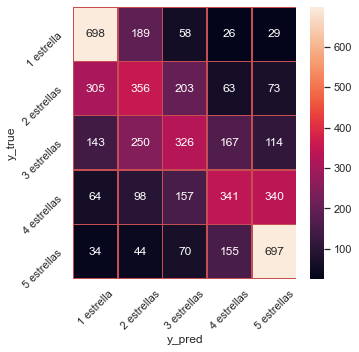

In [74]:
confusion(y_dev,y_dev_pred)

Se puede apreciar una gran mejora en el modelo de Linear SVC, llegando a una presición de casi el 50%, tanto para el train y el test.

Observando la matriz de confusión se determina que el modelo clasifica bien las criticas de 1 y 5 estrellas pero tiene dificultades para clasificar las reviews intermedias.

In [141]:
# Tomamos la lista de palabras y el vector que nos dice la calificación tanto para train y dev
list_review_train = list(data_train1['review_lemm'].values)
calif_train = data_train1['stars'].values

list_review_dev = list(data_dev1['review_lemm'].values)
calif_dev = data_dev1['stars'].values

# Preparamos el conversor de bag of words a vectores que traemos de sklearn.
# Debido a la capacidad de memoria disponible usaremos solo las 1000 palabras con mas frecuencia en todo el corpus 
# para generar los vectores
vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))
# generarnos los vectores para cada review a partir del corpus total.
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_dev = vectorizer.transform(list_review_dev)

# Visualisamos el shape 
print(matriz_review_train.shape)
print(matriz_review_dev.shape)

(200000, 1000)
(5000, 1000)


Anteriormente se estaba vectorizando palabra por palabra, ahora al variar el hiperparámetro "ngram_range" estoy teienendo en cuenta las 1000 palabras más frecuentes, pero estas son una sola palabra y una frase compuesta por 2 palabras. De esta manera le da mayor peso al contexto.

In [142]:
# Cambio los tipos de datos de las matrices para mayor agilidad
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_dev = matriz_review_dev.astype('float32')
calif_dev = calif_dev.astype('int8')

In [143]:
x_train = matriz_review_train.toarray()
y_train = calif_train
x_dev = matriz_review_dev.toarray()
y_dev = calif_dev

#### Linear SVC
Dado los resultados anteriores sigo optimizando este modelo.

In [78]:
svc = LinearSVC(C = 1, random_state=42)
svc.fit(x_train, y_train)
y_train_pred = svc.predict(x_train)
y_dev_pred = svc.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.49236
acc dev:  0.482


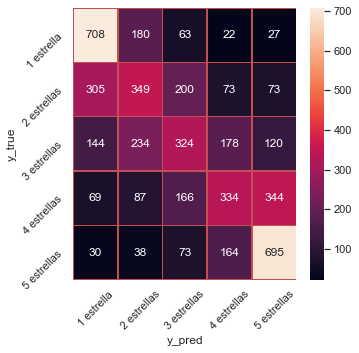

In [79]:
confusion(y_dev,y_dev_pred)

Los rendimientos para el mismo modelo son bastante similares, ahora procedo a optimizar hiperparámetros.

In [80]:
for this_C in [1,3,5,10,40,60,80,100]:
    clf = LinearSVC(C=this_C, random_state=42).fit(x_train,y_train)
    scoretrain = clf.score(x_train,y_train)
    scoretest  = clf.score(x_dev, y_dev)
    print("Linear SVC valor de C:{}, training score :{:2f} , Test Score: {:2f} \n".format(this_C,scoretrain,scoretest))

Linear SVC valor de C:1, training score :0.492360 , Test Score: 0.482000 

Linear SVC valor de C:3, training score :0.492350 , Test Score: 0.482600 

Linear SVC valor de C:5, training score :0.492335 , Test Score: 0.482000 

Linear SVC valor de C:10, training score :0.492340 , Test Score: 0.481800 

Linear SVC valor de C:40, training score :0.492395 , Test Score: 0.481600 

Linear SVC valor de C:60, training score :0.491750 , Test Score: 0.479400 

Linear SVC valor de C:80, training score :0.489585 , Test Score: 0.473400 

Linear SVC valor de C:100, training score :0.489530 , Test Score: 0.479000 



In [144]:
# Instancio el modelo
svc = LinearSVC(dual = False, random_state= 42)
#Parámetros para el RandomizedSearchCV
grid = {'penalty': ['l1', 'l2'],
        'loss' : ['hinge', 'squared_hinge'],
        'tol': [1e-2, 1e-3, 1e-4],
        'multi_class': ['ovr', 'crammer_singer'],
        'C': [2, 3, 4]}

In [145]:
model_svc = RandomizedSearchCV(svc, grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=30, random_state=42)

In [146]:
model_svc.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=LinearSVC(dual=False, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': [2, 3, 4],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'multi_class': ['ovr',
                                                        'crammer_singer'],
                                        'penalty': ['l1', 'l2'],
                                        'tol': [0.01, 0.001, 0.0001]},
                   random_state=42, scoring='accuracy')

In [147]:
print("Mejores parametros: "+str(model_svc.best_params_))
print("Mejor Score: "+str(model_svc.best_score_)+'\n')

Mejores parametros: {'tol': 0.01, 'penalty': 'l1', 'multi_class': 'ovr', 'loss': 'squared_hinge', 'C': 2}
Mejor Score: 0.47811999869889954



In [148]:
pd.DataFrame(model_svc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_penalty,param_multi_class,param_loss,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,94.671089,0.185372,0.000000,0.000000,0.001,l2,ovr,hinge,2,"{'tol': 0.001, 'penalty': 'l2', 'multi_class':...",NaN,NaN,NaN,NaN,NaN,25
1,192.754872,3.032091,15.729839,13.029158,0.0001,l1,ovr,squared_hinge,4,"{'tol': 0.0001, 'penalty': 'l1', 'multi_class'...",0.478723,0.477403,0.478010,0.478045,0.000539,2
2,200.622590,69.801494,9.557534,4.008830,0.01,l1,crammer_singer,squared_hinge,2,"{'tol': 0.01, 'penalty': 'l1', 'multi_class': ...",0.446638,0.441958,0.442789,0.443795,0.002039,10
3,20.379561,4.010698,0.000000,0.000000,0.01,l1,ovr,hinge,2,"{'tol': 0.01, 'penalty': 'l1', 'multi_class': ...",NaN,NaN,NaN,NaN,NaN,28
4,13.097347,1.020728,0.000000,0.000000,0.001,l2,ovr,hinge,3,"{'tol': 0.001, 'penalty': 'l2', 'multi_class':...",NaN,NaN,NaN,NaN,NaN,27
5,9.836571,2.556529,0.000000,0.000000,0.0001,l1,ovr,hinge,4,"{'tol': 0.0001, 'penalty': 'l1', 'multi_class'...",NaN,NaN,NaN,NaN,NaN,26
6,399.762975,13.829325,10.018720,1.081593,0.001,l2,crammer_singer,hinge,2,"{'tol': 0.001, 'penalty': 'l2', 'multi_class':...",0.441313,0.442603,0.445369,0.443095,0.001692,12
7,585.524451,29.397255,5.063636,0.751893,0.001,l2,crammer_singer,hinge,3,"{'tol': 0.001, 'penalty': 'l2', 'multi_class':...",0.443188,0.432448,0.434494,0.436710,0.004656,17
8,25.113410,7.659321,1.247594,0.102446,0.01,l1,ovr,squared_hinge,2,"{'tol': 0.01, 'penalty': 'l1', 'multi_class': ...",0.479143,0.477358,0.477860,0.478120,0.000752,1
9,156.064397,11.622113,2.119518,1.196257,0.01,l1,crammer_singer,hinge,4,"{'tol': 0.01, 'penalty': 'l1', 'multi_class': ...",0.441103,0.433963,0.446359,0.440475,0.005080,15


In [150]:
svc = LinearSVC(dual = False, penalty='l1', tol=0.01, multi_class='ovr', loss='squared_hinge', C=2, random_state=42)
svc.fit(x_train, y_train)
y_train_pred = svc.predict(x_train)
y_dev_pred = svc.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.492355
acc dev:  0.482


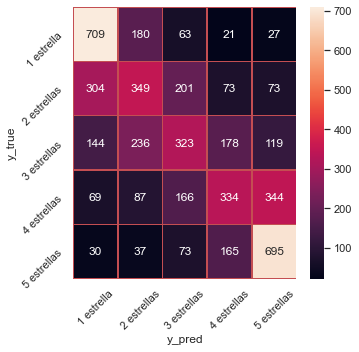

In [151]:
confusion(y_dev,y_dev_pred)

#### Validación
Valido el modelo con el dataset test

In [152]:
# Tomamos la lista de palabras y el vector que nos dice la calificación tanto para train y dev
list_review_train = list(data_train1['review_lemm'].values)
calif_train = data_train1['stars'].values

list_review_test = list(data_test1['review_lemm'].values)
calif_test = data_test1['stars'].values

# Preparamos el conversor de bag of words a vectores que traemos de sklearn.
# Debido a la capacidad de memoria disponible usaremos solo las 1000 palabras con mas frecuencia en todo el corpus 
# para generar los vectores
vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))
# generarnos los vectores para cada review a partir del corpus total.
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_test = vectorizer.transform(list_review_test)

all_words = vectorizer.get_feature_names()

# Visualisamos el shape 
print(matriz_review_train.shape)
print(matriz_review_test.shape)

(200000, 1000)
(5000, 1000)


In [153]:
# Cambio los tipos de datos de las matrices para mayor agilidad
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_test = matriz_review_test.astype('float32')
calif_test = calif_test.astype('int8')

In [154]:
x_train = matriz_review_train.toarray()
y_train = calif_train
x_test = matriz_review_test.toarray()
y_test = calif_test

In [155]:
svc_test = LinearSVC(dual = False, penalty='l1', tol=0.01, multi_class='ovr', loss='squared_hinge', C=2, random_state=42)
svc_test.fit(x_train, y_train)
y_train_pred = svc_test.predict(x_train)
y_test_pred = svc_test.predict(x_test)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc test: ", accuracy_score(y_test, y_test_pred))

acc train:  0.492355
acc test:  0.487


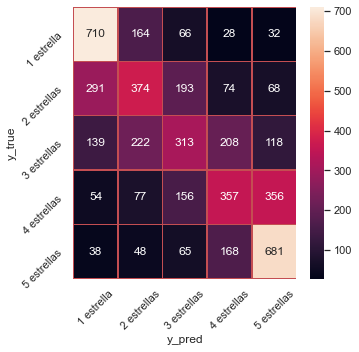

In [156]:
confusion(y_test,y_test_pred)

Se obtienen resultados esperados, el score no es muy alto pero se logro mejorar y se acerca a una presición del 50%. El modelo sigue teniendo dificultad para identificar críticas de 2, 3 y 4 estrellas, pero es muy bueno para identificar los extremos.

#### ¿Qué información está usando el modelo para predecir?
A continuación se generan 5 gráficos con los 10 features positivos mas importantes y los 10 features negativos mas importantes para cada estrella

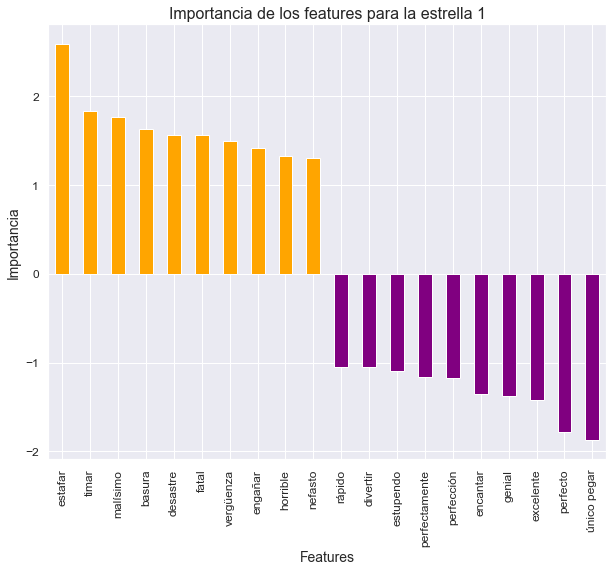

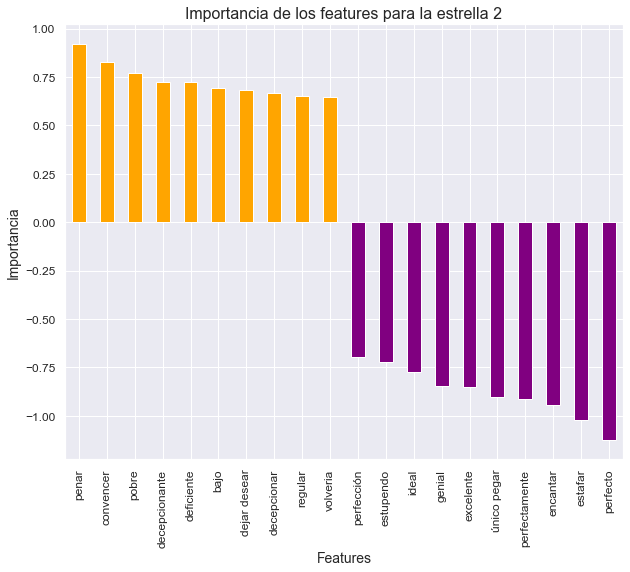

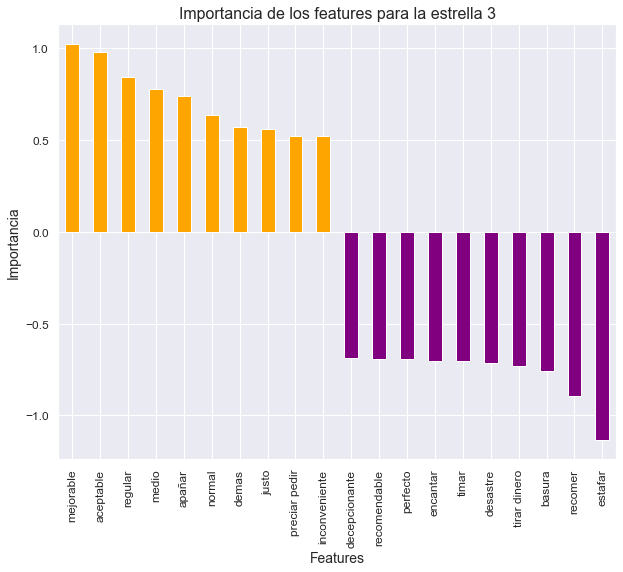

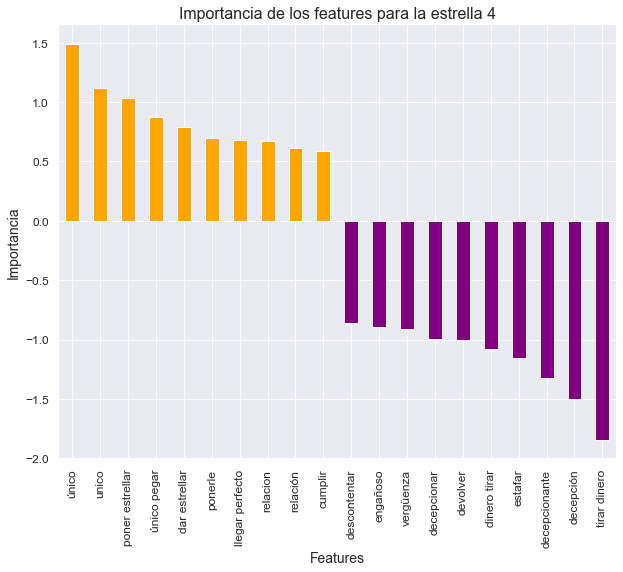

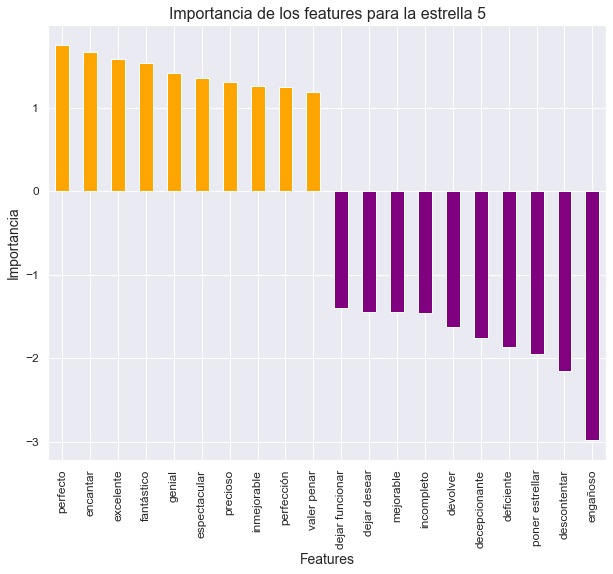

In [157]:
for index_star in range (0,5):
    coeff = list(svc_test.coef_[index_star])
    labels = list(all_words)
    features = pd.DataFrame()
    features['Features'] = labels
    features['Importance'] = coeff
    features = features.reset_index(drop=True)
    features_sort = features.sort_values(by=['Importance'], ascending=False)
    features_sort = features_sort.reset_index(drop=True)
    data_plot = pd.concat([features_sort.head(10), features_sort.tail(10)])
    data_plot.sort_values(by=['Importance'], ascending=False, inplace = True)
    data_plot['positive'] = data_plot['Importance'] > 0
    data_plot.set_index('Features', inplace = True)
    data_plot.Importance.plot(kind='bar', figsize = (10,8),
                              color = data_plot.positive.map({True: 'orange', False: 'purple'}),
                              fontsize=12)
    plt.xlabel ('Features', fontsize=14)
    plt.ylabel ('Importancia', rotation = 90, fontsize=14)
    plt.title ('Importancia de los features para la estrella ' + str(index_star+1), fontsize=16)
    plt.show()

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

Ahora voy a transformar las 5 clases en sólo 2, Bueno y Malo. Espero tener mejor resultados ya qeu se esta simplificando el modelo y le sera mas facil predecir opiniones. A su vez las reviews con valores intermedios suelen ser muy subjetivas y hasta para el ser humano difíciles de identificar, ya que no hay muccha diferencia entre ellas.

La categoría Malo esta compuesto por críticas de 1, 2 y 3 estrellas.

La categoría Bueno esta compuesto por críticas de 4 y 5 estrellas.

In [158]:
diccionario = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1}
data_train1['binomial'] = data_train1['stars'].map(diccionario)
data_train1.head()

,stars,review_body,review_title,product_category,review_full,review_lemm,count_word,binomial
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electronics,television Nevir Nada bueno se me fue ka panta...,television nevir ka pantalla 8 mesar y recibir...,21,0
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electronics,Dinero tirado a la basura con esta compra Horr...,dinero tirar a basura comprar horrible tener c...,31,0
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,drugstore,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar a comprar obligar a comp...,32,0
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto recibir entrar descalificar vendedor ...,63,0
4,1,Llega tarde y co la talla equivocada,Devuelto,shoes,Devuelto Llega tarde y co la talla equivocada,devolver llegar y co tallar equivocar,8,0


In [159]:
diccionario = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1}
data_dev1['binomial'] = data_dev1['stars'].map(diccionario)
data_dev1.head()

,stars,product_category,review_full,count_word,review_lemm,binomial
0,1,wireless,"Mala compra Malisimo, muy grande demasiado apa...",12,malo comprar malisimo grande aparatoso y prote...,0
1,1,apparel,No lo he recibido No he recibido el pedido no ...,12,recibir recibir pedir devolución,0
2,1,sports,Que no aprieta bien en el manillar Tengo que b...,35,apretar manillar buscar sistema funcionar abra...,0
3,1,home_improvement,Brocas de mantequilla Utilicé las brocas de me...,55,broca mantequilla utilizar broca menor diámetr...,0
4,1,beauty,No me gusta No me gusta su olor a viejo y aspe...,13,gustar gustar olor a viejo y aspecto malo,0


In [160]:
diccionario = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1}
data_test1['binomial'] = data_test1['stars'].map(diccionario)
data_test1.head()

,stars,product_category,review_full,count_word,review_lemm,binomial
0,1,wireless,no me llego no me llego el articulo me lo mand...,23,llegar llegar articular mandar correo normal s...,0
1,1,home,amazon sigue sin cumplir en las entregas la me...,13,amazon cumplir entregar mensajería horrible co...,0
2,1,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...,49,estafar enviar decepcionar vendedor pedir a y ...,0
3,1,home,Estafa de Amazon Mi valoración no es sobre el ...,88,estafar amazon valoración producto amazon ofre...,0
4,1,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...,53,conseguir pasar portar kindle interés librar y...,0


In [161]:
# Tomamos la lista de palabras y el vector que nos dice la calificación tanto para train y dev
list_review_train = list(data_train1['review_lemm'].values)
calif_train = data_train1['binomial'].values

list_review_dev = list(data_dev1['review_lemm'].values)
calif_dev = data_dev1['binomial'].values

# Preparamos el conversor de bag of words a vectores que traemos de sklearn.
# Debido a la capacidad de memoria disponible usaremos solo las 1000 palabras con mas frecuencia en todo el corpus 
# para generar los vectores
vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))
# generarnos los vectores para cada review a partir del corpus total.
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_dev = vectorizer.transform(list_review_dev)

# Visualisamos el shape 
print(matriz_review_train.shape)
print(matriz_review_dev.shape)

(200000, 1000)
(5000, 1000)


In [162]:
# Cambio los tipos de datos de las matrices para mayor agilidad
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_dev = matriz_review_dev.astype('float32')
calif_dev = calif_dev.astype('int8')

In [163]:
x_train = matriz_review_train.toarray()
y_train = calif_train
x_dev = matriz_review_dev.toarray()
y_dev = calif_dev

In [164]:
svc = LinearSVC(dual = False, penalty='l1', tol=0.01, multi_class='ovr', loss='squared_hinge', C=2, random_state=42)
svc.fit(x_train, y_train)
y_train_pred = svc.predict(x_train)
y_dev_pred = svc.predict(x_dev)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc dev: ", accuracy_score(y_dev, y_dev_pred))

acc train:  0.81886
acc dev:  0.815


Se pueden observar buenos resultados siendo un modelo prometedor.

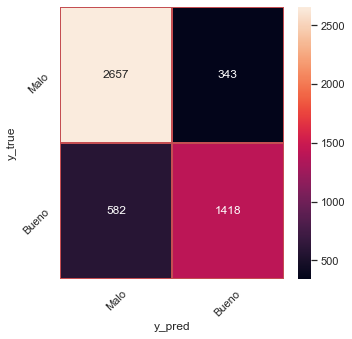

In [165]:
names=['Malo', 'Bueno']
cm=confusion_matrix(y_dev,y_dev_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Analizando la matriz de confusión el modelo tiende a equivocarse más cuando predice comentarios malos, pero en realidad son buenos.

Al convertir el problema de Machine Learning en un problema binario, los datasets han quedado desbalanciados, 60% de los casos son reviews negativos y 40 % positivos. Este grado de desbalance no es muy alto, por lo que el Accuracy sigue siendo una buena metrica para medir el desempeño del modelo.

#### Validación
Valido el modelo con el dataset test

In [166]:
# Tomamos la lista de palabras y el vector que nos dice la calificación tanto para train y dev
list_review_train = list(data_train1['review_lemm'].values)
calif_train = data_train1['binomial'].values

list_review_test = list(data_test1['review_lemm'].values)
calif_test = data_test1['binomial'].values

# Preparamos el conversor de bag of words a vectores que traemos de sklearn.
# Debido a la capacidad de memoria disponible usaremos solo las 1000 palabras con mas frecuencia en todo el corpus 
# para generar los vectores
vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))
# generarnos los vectores para cada review a partir del corpus total.
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_test = vectorizer.transform(list_review_test)

all_words = vectorizer.get_feature_names()

# Visualisamos el shape 
print(matriz_review_train.shape)
print(matriz_review_test.shape)

(200000, 1000)
(5000, 1000)


In [167]:
# Cambio los tipos de datos de las matrices para mayor agilidad
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_test = matriz_review_test.astype('float32')
calif_test = calif_test.astype('int8')

In [168]:
x_train = matriz_review_train.toarray()
y_train = calif_train
x_test = matriz_review_test.toarray()
y_test = calif_test

In [169]:
svc_test = LinearSVC(dual = False, penalty='l1', tol=0.01, multi_class='ovr', loss='squared_hinge', C=2, random_state=42)
svc_test.fit(x_train, y_train)
y_train_pred = svc_test.predict(x_train)
y_test_pred = svc_test.predict(x_test)

print("acc train: ", accuracy_score(y_train, y_train_pred))
print("acc test: ", accuracy_score(y_test, y_test_pred))

acc train:  0.81886
acc test:  0.8186


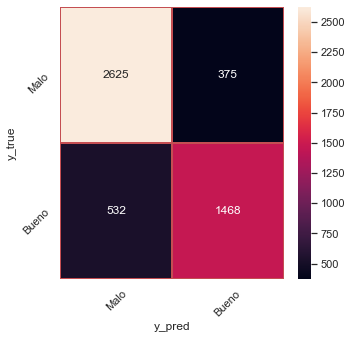

In [170]:
names=['Malo', 'Bueno']
cm=confusion_matrix(y_test,y_test_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Los resultados son muy similares a los obtenidos en el entrenamiento, por lo que me quedo conforme con el modelo planteado.

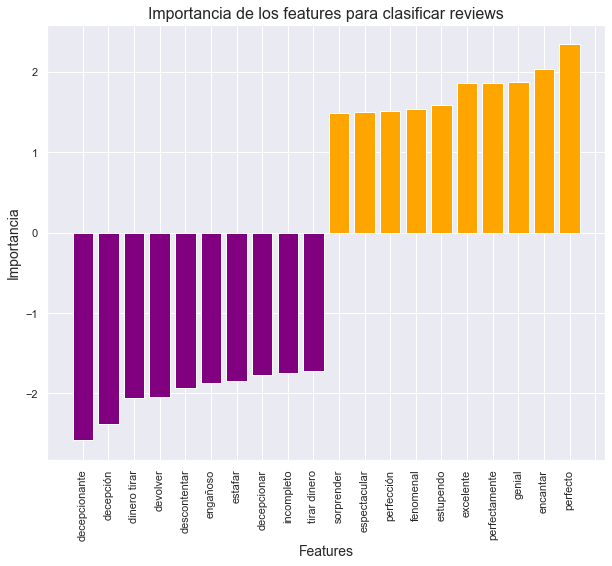

In [171]:
top_features=10
coef = svc_test.coef_.ravel()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

# plot
plt.figure(figsize=(10, 8))
colors = ['purple' if c < 0 else 'orange' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
feature_names = np.array(all_words)
plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=90)
plt.xlabel ('Features', fontsize=14)
plt.ylabel ('Importancia', rotation = 90, fontsize=14)
plt.title ('Importancia de los features para clasificar reviews', fontsize=16)
plt.show()

En el gráfico se pueden ver las 10 variables con mayor importancia para clasificar tanto las críticas negativas como las positivas.

Siendo "decepcionante" la palabra con mayor peso en opiniones malas y "perfecto" en el caso de buenas opioniones, este resultado es muy coherente.